This notebook is to find an illustration for an extreme example that showcases why having different metrics for embedding and clustering affects the results.

We fix our embedding to be Node2Vec and therefore dot similarity. We use K-Means with different metrics as used in the previous notebook. We were worried about convergence issues, but we proceed hoping higher dimensions and sparser points will more likely lead to global maxima.

The protocol is to find a network with extremely stark embedding, and do clustering two ways and visualize the same K-Means results but with different metrics

### Call Alt-Means Clustering from previous notebook
[For now, initialized in this notebook itself]

In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

# Define distance metric functions
def euclidean_distance(X, centroids):
    return cdist(X, centroids, metric='euclidean')

def cosine_distance(X, centroids):
    return  - cosine_similarity(X, centroids)

def dot_distance(X, centroids):
    return -np.dot(X, centroids.T)

def manhattan_distance(X, centroids):
    return cdist(X, centroids, metric='cityblock')

def jaccard_distance(X, centroids):
    return cdist(X, centroids, metric='jaccard')

# Define a mapping from metric names to functions
distance_functions = {
    'euclidean': euclidean_distance,
    'cosine': cosine_distance,
    'dot': dot_distance,
    'manhattan': manhattan_distance,
    'jaccard': jaccard_distance
}

In [2]:
# let's get the machinery going

import numpy as np
from scipy import sparse
import pandas as pd
from copy import deepcopy

from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.linear_model import LogisticRegression 
import faiss
import fast_hdbscan
import embcom

import lfr
import embcom
import csv
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
#from scripts.clustering_methods import clustering_method_values

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
import numpy as np
import belief_propagation
import infomap

from graph_tool.all import Graph,minimize_blockmodel_dl

import graph_tool.all as gt
import numpy as np
import pandas as pd
from scipy import sparse, stats
from scipy.sparse.csgraph import connected_components

# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected
    

### Modifying Alt-Means to accept Euclidean, Dot Sim, & Cosine Sim

In [3]:
 
def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dot",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances

# Only place where GPU is used, need to handle its closing. 
# not entirely sure if faiss.indexflatip gives vectors which have low np.dot(u,v) or low -np.dot(u,v)
def find_knn(target, emb, num_neighbors, metric="dot", device=None): 
    
    if metric == "dot":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    elif metric == "euclidean":
        index = faiss.IndexFlatL2(emb.shape[1])
    elif metric == "manhattan": # incorrect
        index = faiss.IndexFlatL1(emb.shape[1])
    elif metric == "cosine":
        index = faiss.IndexFlatIP(emb.shape[1])
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True) # I believe this emb is normalized but emb outside this function is not
    elif metric=="mahalanobis":
        # THis mathematical trick works, but it needs some reworking in target.astype to
        # give right results.
        # map the vectors back to a space where they follow a unit Gaussian
        xc = emb - emb.mean(0)
        cov = np.dot(xc.T, xc) / xc.shape[0]
        L = np.linalg.cholesky(cov)
        mahalanobis_transform = np.linalg.inv(L)
        emb = np.dot(emb, mahalanobis_transform.T)
        index = faiss.IndexFlatL2(emb.shape[1])
    else:
        raise ValueError("Invalid metric specified.")
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            elif metric == "euclidean":
                index = faiss.IndexFlatL2(emb.shape[1])
            elif metric == "manhattan":
                index = faiss.IndexFlatL1(emb.shape[1])
            elif metric == "cosine":
                index = faiss.IndexFlatIP(emb.shape[1])
                emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            else:
                raise ValueError("Invalid metric specified.")
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
        
    index.reset()
    return indices, distances
    

In [20]:
import numba

# Crucial step is here to modify metric. We need to go from  -(-w0*u_i*u_j +b) to -(-w0* d(u_i,u_j) +b)
def louvain(Z, w1, b0, num_neighbors=100, iteration = 50, device = "cuda:0", return_member_matrix=False, metric='dot'):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()

    cosine_sim_matrix = None
    if metric == 'cosine':
        cosine_sim_matrix = cosine_similarity(Z)
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
                Z=Vt,
                rho=b0/w1,
                num_neighbors=num_neighbors,
                node_size=node_size,
                epochs=iteration,
                device=device,
                metric = metric,
                cosine_sim_matrix=cosine_sim_matrix)
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)

    
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None, epochs=50, metric='dot', cosine_sim_matrix=None): # This involves distance metrics (cosine similarity, atm)
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric=metric,
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        metric = metric,
        epochs=epochs,
        cosine_sim_matrix = cosine_sim_matrix)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,metric, epochs=100, cosine_sim_matrix=None):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    print(rho)
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            # qself = (
            #     np.sum(Z[node_id, :] * Vc[c, :])
            #     - Vnorm[node_id]
            #     - rho * node_size[node_id] * (Nc[c] - node_size[node_id])) # Modifying this line 
 
            # Adjust for cosine similarity using precomputed values
            if (np.all(Z==Vc)) is False:
                print("Bhenchod")
            
            if metric == 'cosine':
                qself = (
                    metric_distance_func(Z[node_id, :], Vc[c, :], metric, cosine_sim_matrix, node_id, c) 
                    - Vnorm[node_id] 
                    - rho * node_size[node_id] * (Nc[c] - node_size[node_id])
                )
            else:
                qself = (
                    metric_distance_func(Z[node_id, :], Vc[c, :], metric) 
                    - Vnorm[node_id] 
                    - rho * node_size[node_id] * (Nc[c] - node_size[node_id])
                )

            
            #print(qself, qself_og)

            for cprime in clist:
                if c == cprime: 
                    continue
                    
                # dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                #        - rho * node_size[node_id] * Nc[cprime]) - qself # and this to include metric functionality

                if metric == 'cosine':
                    dq = (
                        metric_distance_func(Z[node_id, :], Vc[cprime, :], metric, cosine_sim_matrix, node_id, cprime) 
                        - rho * node_size[node_id] * Nc[cprime]
                    ) - qself
                else:
                    dq = (
                        metric_distance_func(Z[node_id, :], Vc[cprime, :], metric) 
                        - rho * node_size[node_id] * Nc[cprime]
                    ) - qself

                
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq

            
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids

# Example usage of alt_means_ootb:
import math
from scipy.spatial.distance import cosine

def metric_distance_func(X, Y, metric, cosine_sim_matrix=None, X_index=None, Y_index=None):
    if metric == 'euclidean':
        return -math.dist(X, Y)
        
    if metric == 'dot':
        return np.sum(X*Y)

    if metric == 'cosine':
        #return np.sum(X*Y/1*1)
        return cosine_sim_matrix[X_index, Y_index]
        #return cosine_similarity([X], [Y])[0][0]



    

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

# Define distance metric functions
def euclidean_distance(X, centroids):
    return cdist(X, centroids, metric='euclidean')

def cosine_distance(X, centroids):
    return 1 - cosine_similarity(X, centroids)

def dot_distance(X, centroids):
    return -np.dot(X, centroids.T)

def manhattan_distance(X, centroids):
    return cdist(X, centroids, metric='cityblock')

def jaccard_distance(X, centroids):
    return cdist(X, centroids, metric='jaccard')

# Define a mapping from metric names to functions
distance_functions = {
    'euclidean': euclidean_distance,
    'cosine': cosine_distance,
    'dot': dot_distance,
    'manhattan': manhattan_distance,
    'jaccard': jaccard_distance
}

# Custom K-Means class
class CustomKMeans:
    def __init__(self, n_clusters=8, metric='euclidean', max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        self.centroids_ = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for i in range(self.max_iter):
            # Calculate distances using the selected metric

            distances = distance_functions[self.metric](X, self.centroids_)

            #distances2 = distance_functions['dot'](X, self.centroids_)

            self.labels_ = np.argmin(distances, axis=1)

            
            #print(np.sum(self.labels_==np.argmin(distances2, axis=1))/len(self.labels_))
            
            # Ensure no empty clusters
            new_centroids = []
            for j in range(self.n_clusters):
                points_in_cluster = X[self.labels_ == j]
                if points_in_cluster.size == 0:
                    # Reassign centroid to a random point
                    new_centroids.append(X[np.random.choice(X.shape[0])])
                else:
                    new_centroids.append(points_in_cluster.mean(axis=0))
            
            new_centroids = np.array(new_centroids)
            
            # Check for convergence
            if np.all(self.centroids_ == new_centroids):
                break
            
            self.centroids_ = new_centroids
        
        return self

    def predict(self, X): 
        # Calculate distances using the selected metric
        distances = distance_functions[self.metric](X, self.centroids_)
        return np.argmin(distances, axis=1)
        
def clustering_method_values(net, community_table, emb, score_keys, device_name, metric=None):



    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    #X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()
    # Clustering

    def proposed_method_labels(emb,device_name):
        # Only use of metric here is getting the neighbors using FAISS in find_knn_edges and then in Louvain

        use_default = True
        
        if use_default is True:
            faiss_metric = 'dot'
        else:
            faiss_metric = metric
        
            
        rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=500, device = device_name, metric = faiss_metric)
        cneg = np.random.choice(emb.shape[0], len(cpos))
        vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

        model = LogisticRegression()
        model.fit(
            np.concatenate([vpos, vneg]).reshape((-1, 1)),
            np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
                )
        w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
        return louvain(emb, w1, b0, device = device_name, metric = metric)

    # Evaluate the clustering
    def method_score(key):
        if key == "kmeans": # Does use k
            n_communities = len(np.unique(community_table['community_id']))
            
            #kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)
            if metric is None:
                kmeans = CustomKMeans(n_clusters=n_communities, metric="euclidean", random_state=42)    
            else:
                kmeans = CustomKMeans(n_clusters=n_communities, metric=metric, random_state=42)# Probably need to remove random_state
                
            kmeans.fit(emb)

            return calc_esim(community_table["community_id"], kmeans.predict(emb))
        
        if key == "dbscan": # Does kinda use k (kinda we give k as minimum cluster size to avoid errors)
            
            clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=len(set(community_table["community_id"])))
            dbscan_labels = clusterer.fit_predict(X)
            return calc_esim(community_table["community_id"], dbscan_labels)
        
        if key == "optics": # Does not use k
            optics = OPTICS().fit(X)
            return calc_esim(community_table["community_id"], optics.labels_)
        
        if key == "proposed": # Does not use k
            return calc_esim(community_table["community_id"], proposed_method_labels(emb,device_name)) 
        
        if key == "xmeans": # Does use k
            # Create instance of X-Means algorithm with MNDL splitting criterion.
            initial_centers = kmeans_plusplus_initializer(X, amount_centers=len(set(community_table['community_id']))).initialize()
            xmeans_mndl = xmeans(X, initial_centers, 20, splitting_type=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH)
            xmeans_mndl.process()
            mndl_clusters = xmeans_mndl.get_clusters()
            xmeans_labels = [i[1] for i in sorted([(j,i) for i in range(len(mndl_clusters)) for j in mndl_clusters[i]])]

            return calc_esim(community_table["community_id"], xmeans_labels)
        
        if key == "belief_prop": # Does use k
            belief_prop_labels = belief_propagation.detect(net, q=len(set(community_table['community_id'])), init_memberships=community_table["community_id"]) 
            return calc_esim(community_table["community_id"], belief_prop_labels)
        
        if key == "infomap": # Does not use k
            r, c, v = sparse.find(net + net.T)
            im = infomap.Infomap(silent=True)
            for i in range(len(r)):
                im.add_link(r[i], c[i], 1)
            im.run()
            
            cids = np.zeros(net.shape[0])
            for node in im.tree:
                if node.is_leaf:
                    cids[node.node_id] = node.module_id
                    
            infomap_labels = np.unique(cids, return_inverse=True)[1]

            return calc_esim(community_table["community_id"], infomap_labels)
            
        if key == "flatsbm": # Does use k
            r, c, v = sparse.find(net)
            g = Graph(directed=False)
            g.add_edge_list(np.vstack([r, c]).T)
            K = len(set(community_table['community_id']))
            state = minimize_blockmodel_dl(
                g,
                state_args={"B_min": K, "B_max": K},
                multilevel_mcmc_args={"B_max": K, "B_min": K},
            )
            b = state.get_blocks()
            flatsbm_labels = np.unique(np.array(b.a), return_inverse=True)[1]
            return calc_esim(community_table["community_id"], flatsbm_labels)
            
    score_dictionary={}
    for key in score_keys:
        score_dictionary[key] = method_score(key)
    
    return score_dictionary

def get_scores(params= None, emb_params = None, score_keys = None, path_name = None, device_name = "cuda:0"):
    
    
    # Defaults
    if params is None:
        params = {
            "N": 100000,     # number of nodes
            "k": 50,       # average degree
            "maxk": 1000,   # maximum degree sqrt(10*N)
            "minc": 50,    # minimum community size
            "maxc": 1000,   # maximum community size sqrt(10*N)
            "tau": 3.0,    # degree exponent
            "tau2": 1.2,   # community size exponent
            "mu": 0.2,     # mixing rate
        }
    if emb_params is None:
        emb_params = {      "method": "node2vec",
                            "window_length": 10,
                            "walk_length": 80,
                            "num_walks": 10,
                            "dim" : 64,
                            }
    
    if score_keys is None:
        score_keys = ['kmeans', 'dbscan', 'optics', 'proposed','xmeans','belief_prop','infomap','flatsbm']
    
    # Allowing existing files in path to be uses. We might need to generate all nets and embeddings first and then proceed to clustering.
    # Easier for snakemake as well.

    net, community_table, emb = create_and_save_network_and_embedding(params,emb_params, path_name, save_file=True)

    return clustering_method_values(net, community_table, emb, score_keys,device_name, metric= metric)
    

# This function is kinda redundant unless you have embedding in hand and want only clusters
def alt_means_ootb(emb, communities, device_name="cuda:0", num_neighbors=500, metric = 'dot', use_default=False): 
    # Here emb is just an array of datapoints, where each row corresponds to a d dimensional array corresponding to a point.
    # Community table is an array with community partitions, which will be converted 
    # below into a pandas dataframe, with 'community_id' column containing the array data.

    

    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    #X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()
    # Clustering

    if use_default is True:
        faiss_metric = 'dot'
    else:
        faiss_metric = metric
        
    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=num_neighbors, device = device_name, metric=faiss_metric)
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
    

    # kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)
    # kmeans_esim = calc_esim(communities, kmeans.labels_)
    # Modify this to include the different metric Kmeans 

    
    proposed_labels = louvain(emb, w1, b0, device = device_name, metric=metric)
    esim = calc_esim(communities, proposed_labels) 
        
    
    return proposed_labels, esim #, kmeans_labels, kmeans_esim 

In [6]:
# Testing if it runs:

### Choose a network

In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Generate SBM Network
n_communities = 4
size = 2000
p_intra = 0.1
p_inter = 0.04
sizes = [size // n_communities] * n_communities
p_matrix = np.full((n_communities, n_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G = nx.stochastic_block_model(sizes, p_matrix)
true_labels = [i for i, s in enumerate(sizes) for _ in range(s)]

community_table = pd.DataFrame({'community_id': true_labels})

### Get Embeddings

In [8]:
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")
from scripts.nets_and_embeddings import *
emb = create_embedding(G, emb_params = {
                                    "method": "node2vec",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : 64 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)



In [9]:
i=10
j=10
1 - cosine(normalized_emb[i],normalized_emb[j]) ,cosine_similarity(normalized_emb)[i][j]

(1, 0.9999999999999998)

In [22]:
proposed_labels, esim = alt_means_ootb(normalized_emb, true_labels, device_name="cuda:0", num_neighbors=500, metric = 'cosine')
proposed_labels, esim

0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633
0.8089863494109633


(array([0., 0., 0., ..., 0., 0., 0.]), 0.0)

In [20]:
proposed_labels, esim = alt_means_ootb(emb, true_labels, device_name="cuda:0", num_neighbors=500, metric = 'dot')
proposed_labels, esim

0.9943055976836362
0.9943055976836362


(array([0., 0., 0., ..., 3., 3., 3.]), 0.9801424277106737)

In [12]:
proposed_labels, esim = alt_means_ootb(emb, true_labels, device_name="cuda:0", num_neighbors=500, metric = 'dot')
proposed_labels, esim

1.0861841111687216
1.0861841111687216
1.0861841111687216


(array([17., 17., 17., ..., 68., 68., 68.]), 0.8406534193931985)

In [ ]:
clustering_method_values(G, community_table,emb,['kmeans', 'proposed'],"cuda:0", metric='dot')

My hypothesis for why switching to euclidean doesn't work is that, in the case of modularity Aij term is 0 or 1, and ther kikj term is normalized by 2m, which allows for modularity to always be bounded between [-0.5,1], even when we use dot sim, the scale seems to be bounded better than euclidean distance, so it doesn't affect boundedness for dot vs euclidean it does.

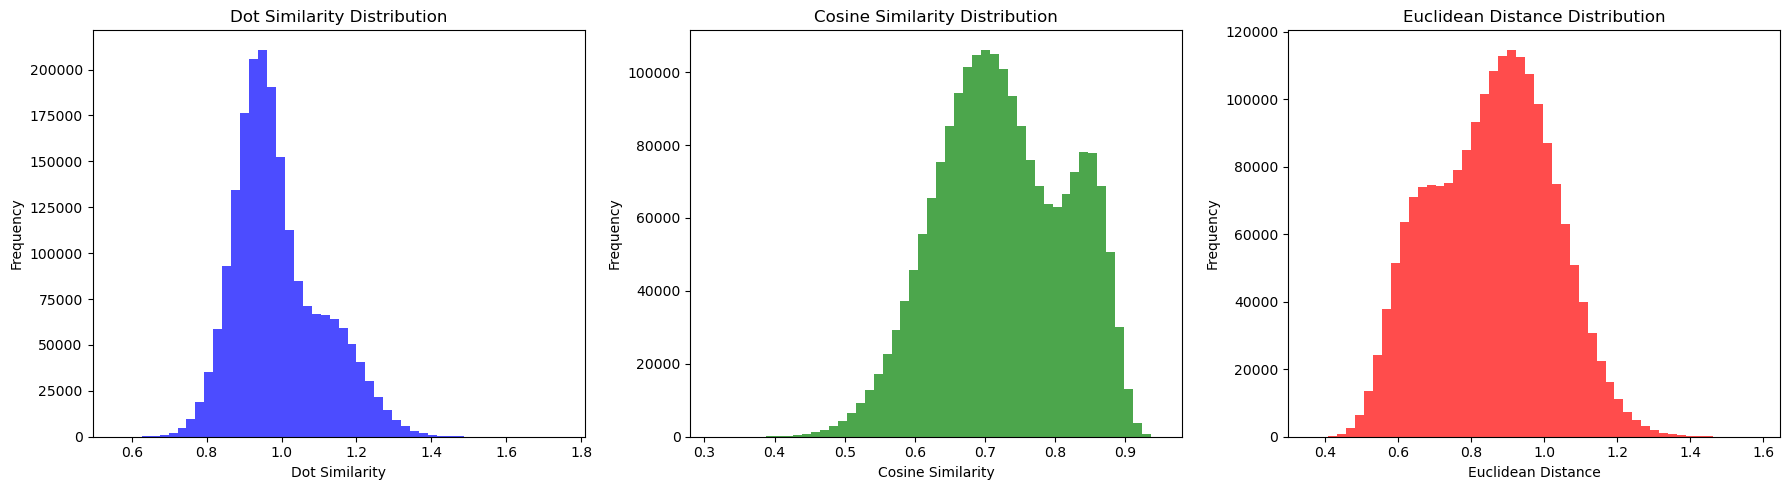

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform


# Calculate pairwise distances without redundancy using dot product, cosine, and Euclidean metrics
dot_similarity = np.dot(emb, emb.T)
cosine_sim = 1 - pdist(emb, 'cosine')
euclidean_distance = pdist(emb, 'euclidean')

# Mask to get only the lower triangular part (without diagonal) for dot similarity
tril_indices = np.tril_indices_from(dot_similarity, k=-1)
dot_similarity_values = dot_similarity[tril_indices]

# Plotting the distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dot similarity distribution
axes[0].hist(dot_similarity_values, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Dot Similarity Distribution')
axes[0].set_xlabel('Dot Similarity')
axes[0].set_ylabel('Frequency')

# Cosine similarity distribution
axes[1].hist(cosine_sim, bins=50, color='green', alpha=0.7)
axes[1].set_title('Cosine Similarity Distribution')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# Euclidean distance distribution
axes[2].hist(euclidean_distance, bins=50, color='red', alpha=0.7)
axes[2].set_title('Euclidean Distance Distribution')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Suppose i normalize the embeddings

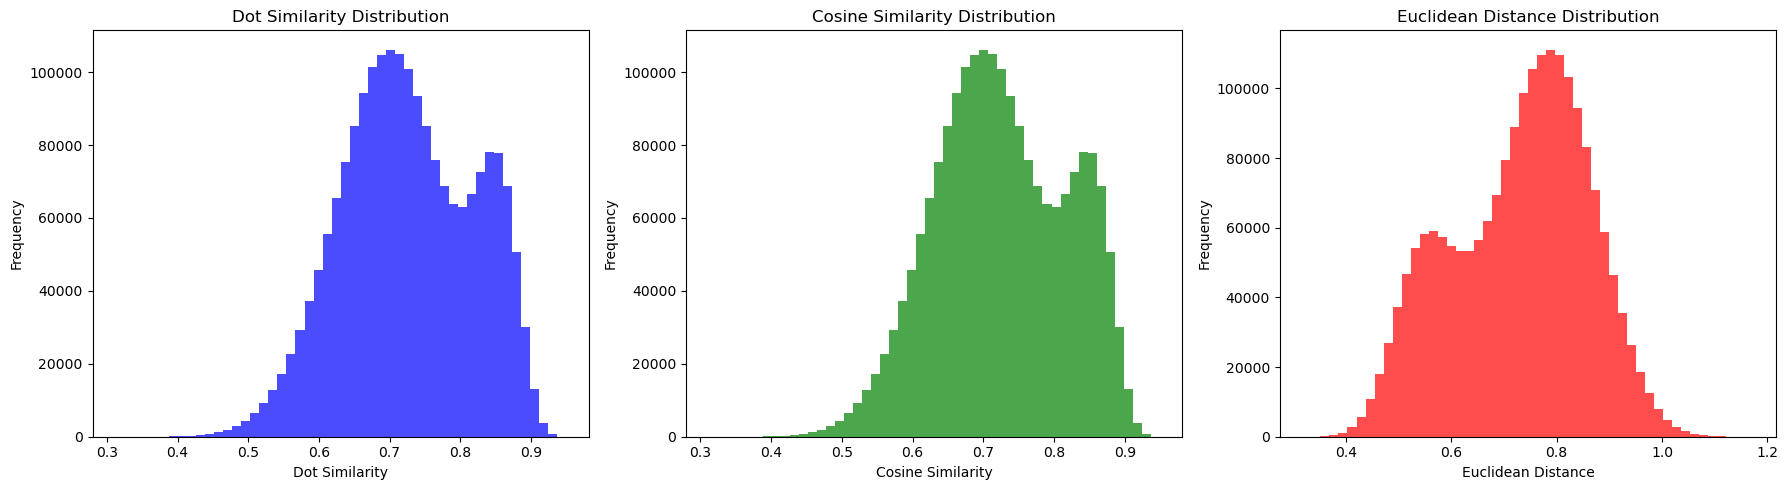

In [14]:
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

# Calculate pairwise distances without redundancy using dot product, cosine, and Euclidean metrics
dot_similarity = np.dot(normalized_emb, normalized_emb.T)
cosine_sim = 1 - pdist(normalized_emb, 'cosine')
euclidean_distance = pdist(normalized_emb, 'euclidean')

# Mask to get only the lower triangular part (without diagonal) for dot similarity
tril_indices = np.tril_indices_from(dot_similarity, k=-1)
dot_similarity_values = dot_similarity[tril_indices]

# Plotting the distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dot similarity distribution
axes[0].hist(dot_similarity_values, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Dot Similarity Distribution')
axes[0].set_xlabel('Dot Similarity')
axes[0].set_ylabel('Frequency')

# Cosine similarity distribution
axes[1].hist(cosine_sim, bins=50, color='green', alpha=0.7)
axes[1].set_title('Cosine Similarity Distribution')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')

# Euclidean distance distribution
axes[2].hist(euclidean_distance, bins=50, color='red', alpha=0.7)
axes[2].set_title('Euclidean Distance Distribution')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
So normalizing should still give me good results, right?

In [15]:
print("metric, esim without normalizing, esim with norm")

for metric in ['dot','cosine', 'euclidean']:
    proposed_labels, esim1 = alt_means_ootb(emb, true_labels, device_name="cuda:0", num_neighbors=500, metric = metric)
    proposed_labels, esim2 = alt_means_ootb(normalized_emb, true_labels, device_name="cuda:0", num_neighbors=500, metric = metric)
    print(metric, esim1, esim2)

metric, esim without normalizing, esim with norm
dot 0.8429316015206785 0.9102242495836018
cosine 0.0 0.0075421133778686604
euclidean 0.0 0.0015007503751875944


Why does dot and cosine not have identical values?

In [ ]:
# Example usage:
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score,normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Initialize CustomKMeans with different metrics

metrics = ['euclidean', 'dot', 'cosine', 'manhattan', 'jaccard']
kmeans_models = {}


for metric in metrics:
    kmeans = CustomKMeans(n_clusters=n_communities, metric=metric, random_state=2)
    kmeans.fit(emb)
    kmeans_models[metric] = kmeans



# Reduce the dimensionality of embeddings to 2D using PCA
# PCA cuz it keeps it consistent and preserves global structure without adding stochasticity for easy comparison
# pca = PCA(n_components=2)
# emb_2d = pca.fit_transform(emb)

from sklearn.manifold import TSNE

# Reduce the dimensionality of embeddings to 2D using t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# emb_2d = tsne.fit_transform(emb)


umap_model = umap.UMAP(n_components=2, random_state=42)
emb_2d = umap_model.fit_transform(emb)
    
# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

#Ground truth plot
axes[0].scatter(emb_2d[:, 0], emb_2d[:, 1], c=true_labels, s=50, cmap='viridis')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('PCA Feature 1')
axes[0].set_ylabel('PCA Feature 2')

for i, metric in enumerate(metrics):
    y_pred = kmeans_models[metric].predict(emb)
    
    # Reduce centroids to 2D using PCA
    #centroids_2d = pca.transform(kmeans_models[metric].centroids_)

    # Calculate performance metrics
    ari = adjusted_rand_score(true_labels, y_pred)
    nmi  = normalized_mutual_info_score(true_labels, y_pred)
    
    
    axes[i+1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=y_pred, s=50, cmap='viridis')
    #
    #axes[i+1].scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='red', marker='X')
    axes[i+1].set_title(f'Metric: {metric.capitalize()}\nARI: {ari:.2f}, NMI: {nmi:.2f}')
    axes[i+1].set_xlabel('PCA Feature 1')
    axes[i+1].set_ylabel('PCA Feature 2')

# Adjust layout
plt.tight_layout()
plt.show()

NameError: name 'n_communities' is not defined

In [ ]:
# Why is it so similar to each other?